In [1]:
import os 
root_dir = os.path.abspath('')
os.chdir(root_dir)

# Library

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.eda import *
from src.feat_select import *

(CVXPY) Mar 15 11:02:24 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 15 11:02:24 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [4]:
import importlib
from src import eda
importlib.reload(eda)
from src.eda import *

In [5]:
df = pd.read_csv('data/train_data.txt')
df_test = pd.read_csv('data/test_data.txt')

In [12]:
print('Train: ', len(df))
print('Test: ', len(df_test))

Train:  5822
Test:  4000


In [13]:
print('Event rate ', df['86'].value_counts()/len(df['86']))

Event rate  86
0    0.940227
1    0.059773
Name: count, dtype: float64


In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5822 non-null   int64
 1   1       5822 non-null   int64
 2   2       5822 non-null   int64
 3   3       5822 non-null   int64
 4   4       5822 non-null   int64
 5   5       5822 non-null   int64
 6   6       5822 non-null   int64
 7   7       5822 non-null   int64
 8   8       5822 non-null   int64
 9   9       5822 non-null   int64
 10  10      5822 non-null   int64
 11  11      5822 non-null   int64
 12  12      5822 non-null   int64
 13  13      5822 non-null   int64
 14  14      5822 non-null   int64
 15  15      5822 non-null   int64
 16  16      5822 non-null   int64
 17  17      5822 non-null   int64
 18  18      5822 non-null   int64
 19  19      5822 non-null   int64
 20  20      5822 non-null   int64
 21  21      5822 non-null   int64
 22  22      5822 non-null   int64
 23  23      5822 

In [8]:
demo_feat = [str(i) for i in range(1,43)]
prod_own_feat = [str(i) for i in range(43, 86)]
label = ['86']

# Data processing + Feature creation

In [9]:
def regroup(row):
    if row in (1,2,3,4,7):
        return 3
    elif row in (8,9,10,11,12,13,14,15,22,26,27,28,29,30,34,35,36,37,38):
        return 2
    elif row in (16,17,18,19,21,23,24,25,31,33,41):
        return 1
    else:
        return 0

In [14]:
df['social_class'] = df['1'].apply(lambda row: regroup(row)) 

In [15]:
def most_cat(df, feature):
    total_obs = len(df)
    most_cat = df[feature].value_counts().max()
    rate = most_cat/total_obs
    return rate

In [16]:
frequency_rate = {'feature':[], 'rate':[]}
for feature in (demo_feat+prod_own_feat):
    frequency_rate['feature'].append(feature)
    frequency_rate['rate'].append(most_cat(df, feature))

In [17]:
freq_rate = pd.DataFrame(frequency_rate).sort_values(by='rate', ascending=False).reset_index(drop=True)
drop_list = list(freq_rate[freq_rate['rate']>= 0.8].feature)

In [18]:
#total contribution level/amount
df['total_con_level'] = df.iloc[:, 44:66].sum(axis=1)

#total number of policy owned
df['total_no_policy'] = df.iloc[:, 65:86].sum(axis=1)

#total amount contributed per policies
for amt, count in zip(range(44,65), range(65,86)):
    df[f'{amt}_amt'] = df[f'{amt}']*df[f'{count}']

In [19]:
#scan to see which policies have the most contribution/ownership amount

df.iloc[:, 90:111].sum(axis=0).sort_values(ascending=False)

#47 = car insurance
#59 = fire insurance
#44 = private 3rd party insurance
#55 = life insurance

47_amt    19142
59_amt    11388
44_amt     4507
55_amt     1765
54_amt     1305
49_amt     1124
52_amt      804
46_amt      417
48_amt      366
64_amt      280
45_amt      257
62_amt      185
58_amt      161
51_amt      152
53_amt      151
61_amt      118
63_amt       95
57_amt       89
50_amt       85
56_amt       80
60_amt        5
dtype: int64

In [20]:
#total amount all policies
df['total_all_policy'] = df.iloc[:, 90:111].sum(axis=1)

def treat_divide_by_zero(df, feat):
    set_limit = df[df[feat]!=np.inf][feat].max()
    df[feat] = df[feat].replace({np.inf:set_limit, -np.inf:0})

#ratio average income/total amount all policies
df['income_vs_policy'] = df['42']/df['total_all_policy']
treat_divide_by_zero(df, 'income_vs_policy')

#ratio average income/insurance type (most popular types)
for i in [47,59,44,55]:
    new_col = f'income_vs{i}'
    df[new_col]=df['42']/df[f'{i}_amt']
    treat_divide_by_zero(df, new_col)

df.fillna(0, inplace=True)

In [21]:
def data_processing(df_input):

    df = df_input.copy()
    df['social_class'] = df['1'].apply(lambda row: regroup(row)) 
    #total contribution level/amount
    df['total_con_level'] = df.iloc[:, 44:66].sum(axis=1)
    
    #total number of policy owned
    df['total_no_policy'] = df.iloc[:, 65:86].sum(axis=1)
    
    #total amount contributed per policies
    for amt, count in zip(range(44,65), range(65,86)):
        df[f'{amt}_amt'] = df[f'{amt}']*df[f'{count}']
    #total amount all policies
    df['total_all_policy'] = df.iloc[:, 90:111].sum(axis=1)
    
    def treat_divide_by_zero(df, feat):
        set_limit = df[df[feat]!=np.inf][feat].max()
        df[feat] = df[feat].replace({np.inf:set_limit, -np.inf:0})
    
    #ratio average income/total amount all policies
    df['income_vs_policy'] = df['42']/df['total_all_policy']
    treat_divide_by_zero(df, 'income_vs_policy')
    
    #ratio average income/insurance type (most popular types)
    for i in [47,59,44,55]:
        new_col = f'income_vs{i}'
        df[new_col]=df['42']/df[f'{i}_amt']
        treat_divide_by_zero(df, new_col)

    df.fillna(0, inplace=True)        
    return df

In [22]:
df_test['86']=None

In [23]:
df_test_final = data_processing(df_test)

In [24]:
df = data_processing(df)

# EDA

In [25]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 117 columns):
 #    Column            Non-Null Count  Dtype  
---   ------            --------------  -----  
 0    ID                5822 non-null   int64  
 1    1                 5822 non-null   int64  
 2    2                 5822 non-null   int64  
 3    3                 5822 non-null   int64  
 4    4                 5822 non-null   int64  
 5    5                 5822 non-null   int64  
 6    6                 5822 non-null   int64  
 7    7                 5822 non-null   int64  
 8    8                 5822 non-null   int64  
 9    9                 5822 non-null   int64  
 10   10                5822 non-null   int64  
 11   11                5822 non-null   int64  
 12   12                5822 non-null   int64  
 13   13                5822 non-null   int64  
 14   14                5822 non-null   int64  
 15   15                5822 non-null   int64  
 16   16                5822

<Figure size 640x480 with 0 Axes>

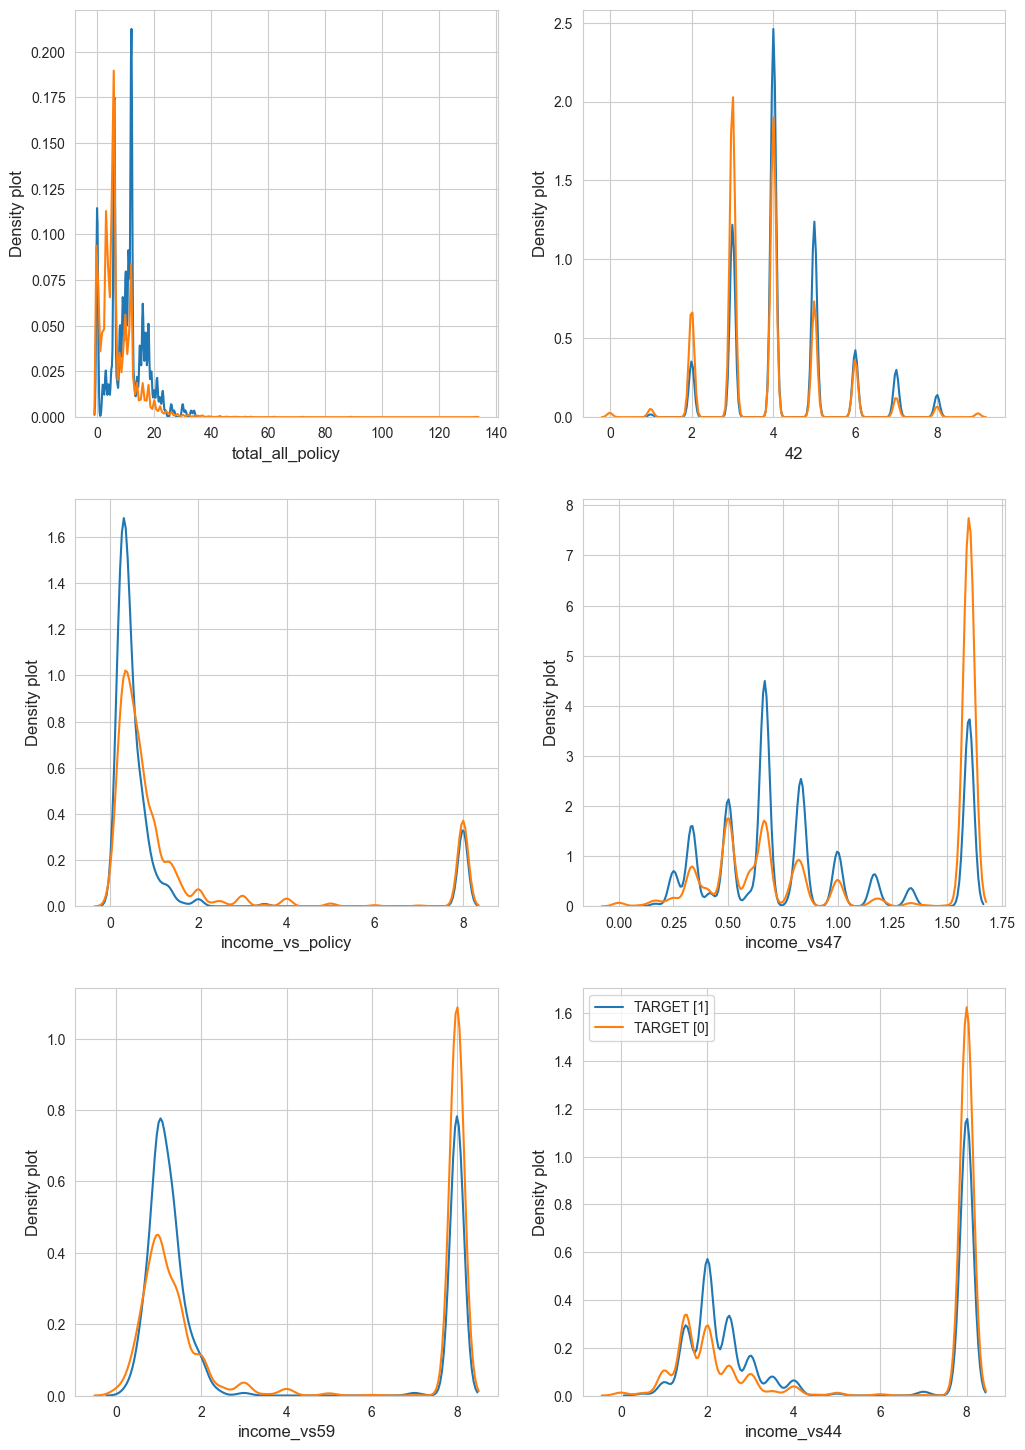

In [26]:
plot_distribution_target(df, ['total_all_policy', '42', 'income_vs_policy', 'income_vs47', 'income_vs59', 'income_vs44'], label[0], nrows=3, bw_method=0.05)

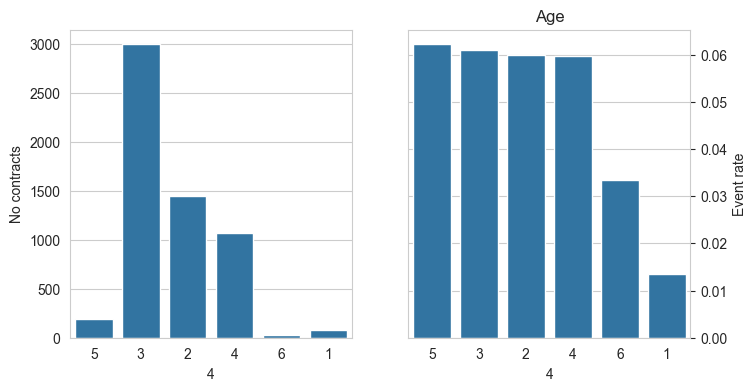

In [27]:
plot_stats('4', label[0], df, title='Age')

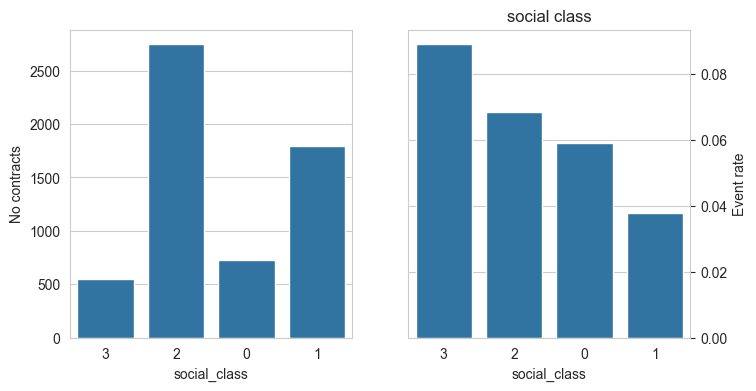

In [28]:
plot_stats('social_class', label[0], df, title='social class')

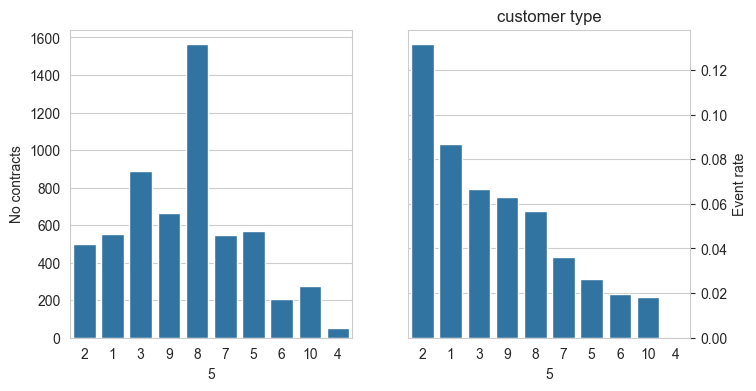

In [29]:
plot_stats('5', label[0], df, title='customer type')

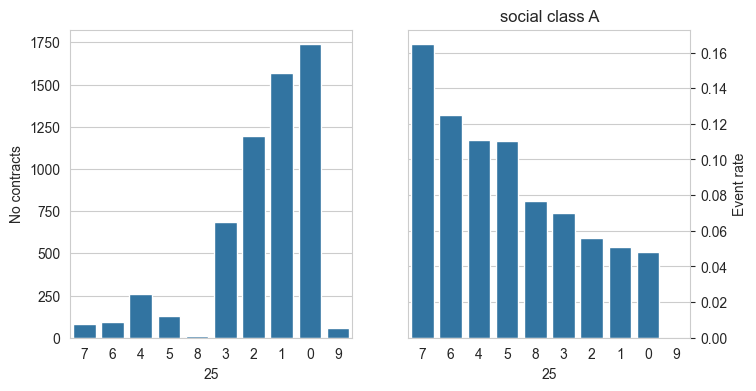

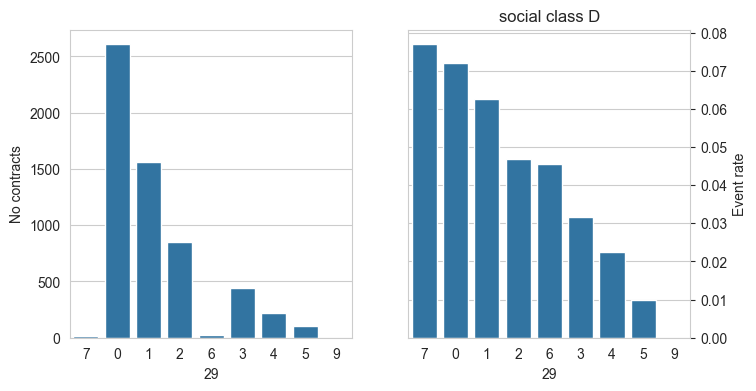

In [30]:
plot_stats('25', label[0], df, title='social class A')
plot_stats('29', label[0], df, title='social class D')

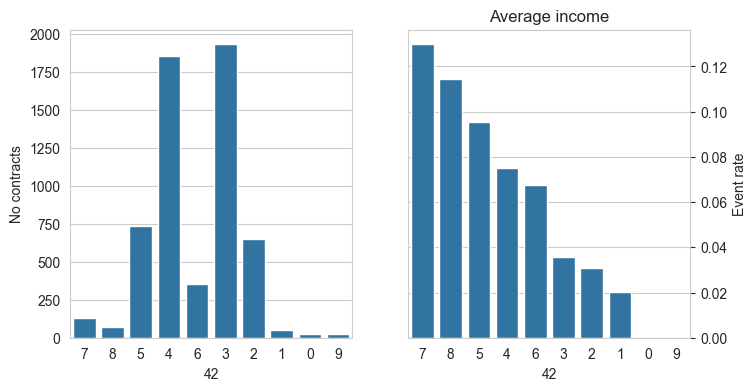

In [31]:
plot_stats('42', label[0], df, title='Average income')

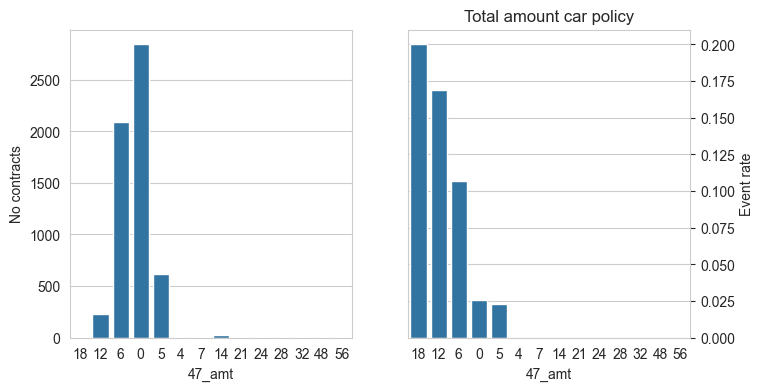

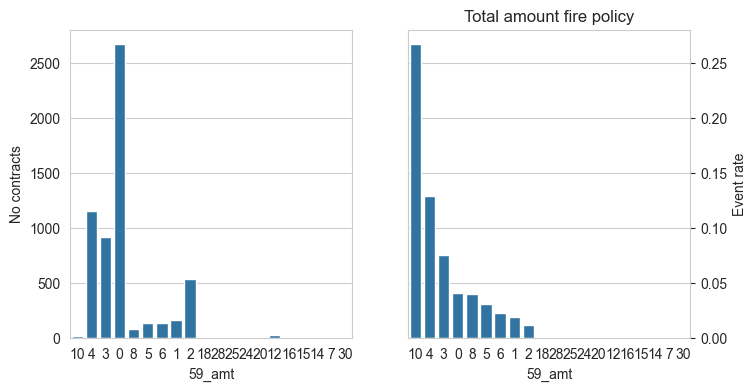

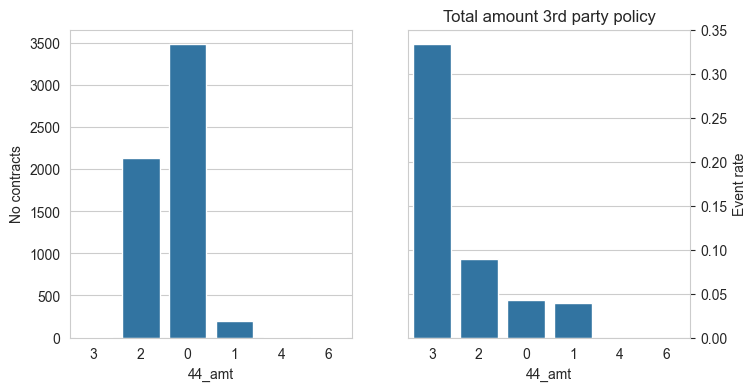

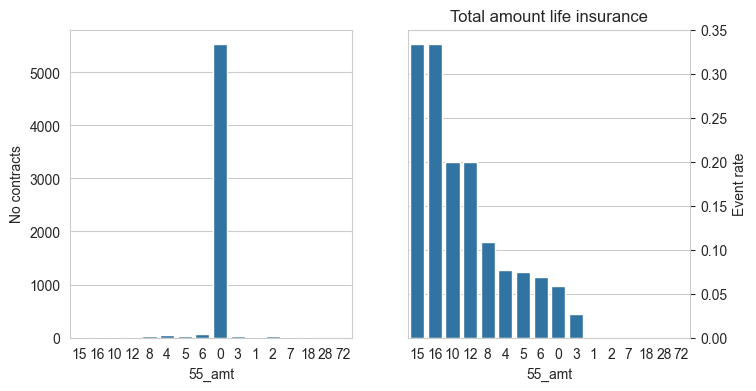

In [32]:
plot_stats('47_amt', label[0], df, title='Total amount car policy')
plot_stats('59_amt', label[0], df, title='Total amount fire policy')
plot_stats('44_amt', label[0], df, title='Total amount 3rd party policy')
plot_stats('55_amt', label[0], df, title='Total amount life insurance')

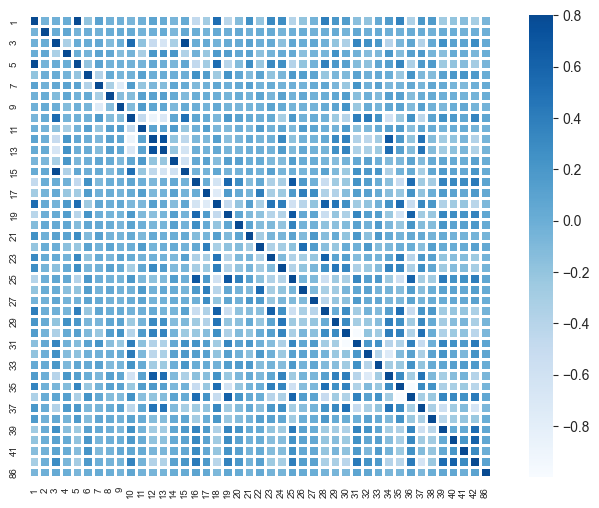

In [33]:
plot_corr_matrix(df[demo_feat+label])

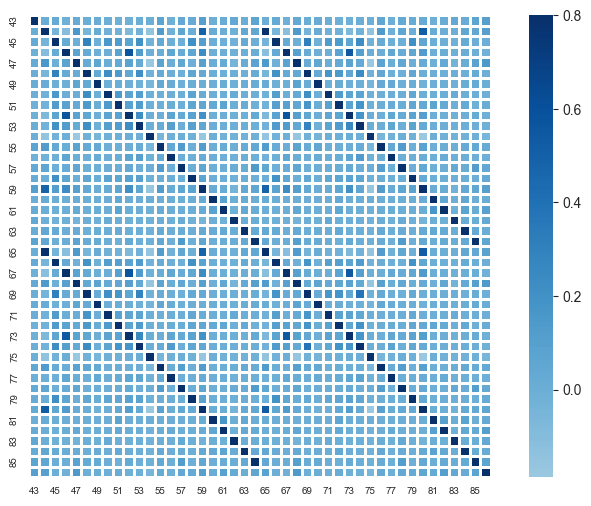

In [34]:
plot_corr_matrix(df[prod_own_feat+label])

# Feature selection

In [35]:
import optbinning
from optbinning import OptimalBinning
from sklearn.feature_selection import f_classif, chi2

In [36]:
feature_list_1 = list(set(df.columns) - set(['ID']+label) - set(drop_list))

In [37]:
len(feature_list_1)

77

In [38]:
df[feature_list_1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   15                5822 non-null   int64  
 1   68                5822 non-null   int64  
 2   53_amt            5822 non-null   int64  
 3   29                5822 non-null   int64  
 4   43                5822 non-null   int64  
 5   47                5822 non-null   int64  
 6   58_amt            5822 non-null   int64  
 7   56_amt            5822 non-null   int64  
 8   44                5822 non-null   int64  
 9   45_amt            5822 non-null   int64  
 10  social_class      5822 non-null   int64  
 11  21                5822 non-null   int64  
 12  8                 5822 non-null   int64  
 13  22                5822 non-null   int64  
 14  17                5822 non-null   int64  
 15  50_amt            5822 non-null   int64  
 16  income_vs_policy  5822 non-null   float64


In [40]:
stat_table = feature_ranking(df, label[0], feature_list_1)

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 26.74it/s]


In [42]:
stat_table.sort_values(by='iv', ascending=False)

,feature,iv,pval_test
73,total_con_level,0.847230,5.129102e-115
69,total_all_policy,0.732931,5.048541e-128
21,47_amt,0.586539,4.640674e-112
5,47,0.586539,8.797634e-85
39,income_vs47,0.501356,2.499469e-18
54,total_no_policy,0.437921,6.419584e-26
1,68,0.410574,7.021023e-19
16,income_vs_policy,0.359623,1.709150e-03
43,59,0.359368,1.288395e-23
24,59_amt,0.355700,4.213306e-20


In [43]:
filter_result = stat_table.query("iv > 0.02")\
            .query("pval_test <= 0.05|pval_test.isnull()")

In [44]:
feature_list_2 = list(filter_result['feature'])

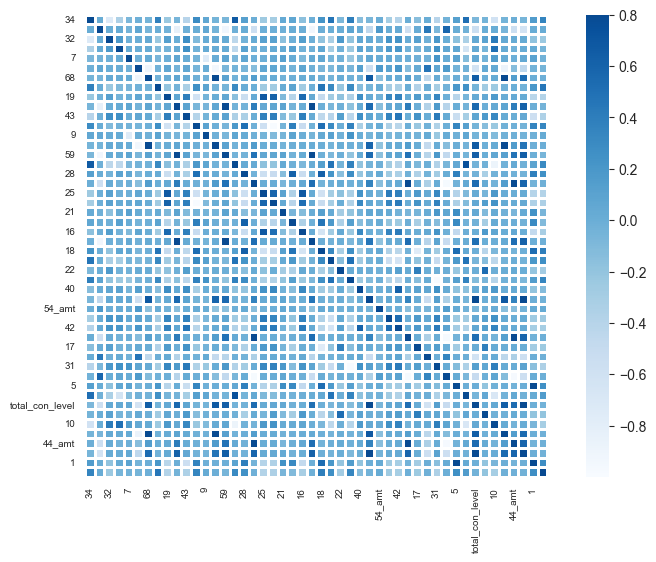

In [45]:
plot_corr_matrix(df[list(set(feature_list_2) - set(['social_class']))])

In [46]:
co = df[list(set(feature_list_2) - set(['social_class']))].corr().abs()

In [47]:
co_df = pd.DataFrame(co.unstack(), columns=['corr'])

In [48]:
co_df.query('corr > 0.8 & corr <1')

corr
income_vs59      59_amt            0.820596
                 59                0.924455
                 80                0.927796
income_vs47      68                0.898548
                 47                0.933146
                 47_amt            0.875126
68               income_vs47       0.898548
                 47                0.916154
                 47_amt            0.992464
59_amt           income_vs59       0.820596
                 59                0.906280
                 80                0.906486
35               36                0.999239
47               income_vs47       0.933146
                 68                0.916154
                 47_amt            0.892514
59               income_vs59       0.924455
                 59_amt            0.906280
                 80                0.865536
12               10                0.884362
44               65                0.981369
                 income_vs44       0.973980
                 44_amt            0.995538
36               35                0.999239
80               income_vs59       0.927796
                 59_amt            0.906486
                 59                0.865536
30               31                0.999554
total_all_policy total_con_level   0.899243
                 total_no_policy   0.918721
65               44                0.981369
                 income_vs44       0.971437
                 44_amt            0.980246
31               30                0.999554
income_vs44      44                0.973980
                 65                0.971437
                 44_amt            0.968048
5                1                 0.992672
total_con_level  total_all_policy  0.899243
                 total_no_policy   0.911536
10               12                0.884362
47_amt           income_vs47       0.875126
                 68                0.992464
                 47                0.892514
44_amt           44                0.995538
                 65                0.980246
                 income_vs44       0.968048
total_no_policy  total_all_policy  0.918721
                 total_con_level   0.911536
1                5                 0.992672

In [50]:
drop_list2 = ['total_con_level', 'total_all_policy',
              '59', 'income_vs59', '80'
              '1',
              '35', 
              '44', '65', 'income_vs44',
              '47', 'income_vs47', '68'
             '30']

In [51]:
len(drop_list2)

12

In [52]:
feature_list3 = list(set(feature_list_2)-set(drop_list2))

In [53]:
df[feature_list3].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   34                5822 non-null   int64  
 1   32                5822 non-null   int64  
 2   7                 5822 non-null   int64  
 3   15                5822 non-null   int64  
 4   68                5822 non-null   int64  
 5   29                5822 non-null   int64  
 6   19                5822 non-null   int64  
 7   59_amt            5822 non-null   int64  
 8   43                5822 non-null   int64  
 9   9                 5822 non-null   int64  
 10  12                5822 non-null   int64  
 11  44_amt            5822 non-null   int64  
 12  28                5822 non-null   int64  
 13  25                5822 non-null   int64  
 14  36                5822 non-null   int64  
 15  social_class      5822 non-null   int64  
 16  21                5822 non-null   int64  


# Training and evaluation

In [54]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble  import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [55]:
X = df[feature_list3]
y = df[label[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1000)

In [ ]:
for i in [180, 190, 200, 210, 230, 250, 270, 290]:
    clf = RandomForestClassifier(n_estimators = i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    accuracy = metrics.roc_auc_score(y_test, y_pred)
    print(f"N_estimator {i} - AUC: {accuracy}", )

In [ ]:
for i in [20, 50, 100, 200, 300, 500, 800, 1000]:
    clf = RandomForestClassifier(n_estimators = i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    accuracy = metrics.roc_auc_score(y_test, y_pred)
    print(f"N_estimator {i} - AUC: {accuracy}", )

In [59]:
clf = RandomForestClassifier(n_estimators = 220, random_state=100)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"Baseline model with AUC: {auc}")

Baseline model with AUC: 0.7064829708371215


In [60]:
import pickle
filename = 'models/RandomForestTrial-baseline.sav'
pickle.dump(clf, open(filename, 'wb'))

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

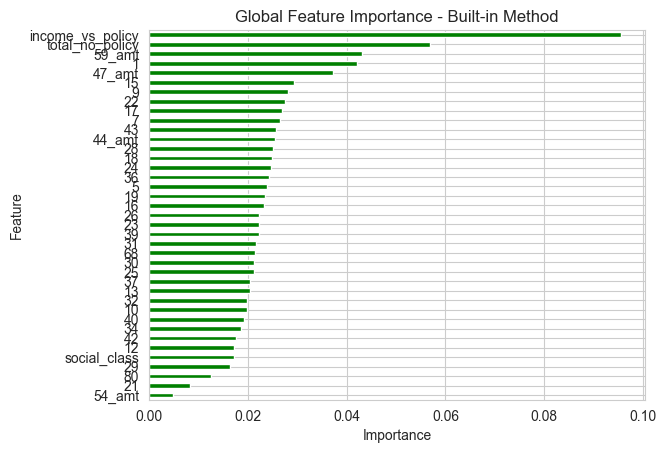

In [61]:
import matplotlib.pyplot as plt
global_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [62]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "iterations": trial.suggest_int("iterations", 100, 200),
        "l2_leaf_reg": trial.suggest_loguniform('l2_leaf_reg', 1, 100),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 300),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "bagging_temperature": trial.suggest_loguniform('bagging_temperature', 0.1, 20.0),
        "depth": trial.suggest_int("depth", 1, 6),
        "random_seed": 42
    }
    clf = CatBoostClassifier(**params, silent=True)
    scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    final_score = scores.mean()
    deviation = scores.std()
    print("%0.2f ROC_AUC with a standard deviation of %0.6f" % (final_score, deviation))
    return final_score, deviation

In [ ]:
study = optuna.create_study(directions=['maximize', 'minimize'], sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial2 = study2.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial2.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
trial2.params

In [ ]:
final_clf = CatBoostClassifier(**trial2.params, silent=True, random_seed=100)
final_clf.fit(X, y)

In [ ]:
import pickle
filename = 'models/CatBoostTrial1.sav'
pickle.dump(final_clf, open(filename, 'wb'))

In [ ]:
submit = final_clf.predict_proba(df_test_final[feature_list3])[:, 1]

In [ ]:
y_test = pd.read_csv(r'data/tictgts2000.txt', header=None)

In [ ]:
y_test['submit']=submit

In [ ]:
y_test[['submit']].value_counts().sort_index()

In [ ]:
y_test.sort_values(by='submit', ascending=False).iloc[:1200]

In [ ]:
y_test[['submit']].hist(range=(0,0.1))

In [ ]:
len(y_test[(y_test[0]==1) &(y_test['submit']>0.043264)])

In [ ]:
len(y_test[(y_test[0]==1) &(y_test['submit']<=0.043264)])

In [ ]:
len(y_test[(y_test[0]==0) &(y_test['submit']>0.06)])

In [ ]:
len(y_test[(y_test[0]==0) &(y_test['submit']<=0.06)])

# Model calibration using Conformal prediction

In [ ]:
from src import VennABERS

In [ ]:
X_test = df_test_final[feature_list3]
y_test = y_test

In [ ]:
??VennABERS.ScoresToMultiProbs

In [ ]:
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(y_train.value_counts())
print(y_calib.value_counts())

In [ ]:
final_clf2 = CatBoostClassifier(**trial2.params, silent=True, random_seed=42)
final_clf2.fit(X_train, y_train)

In [ ]:
import pickle
filename = 'models/CatBoostTrial2.sav'
pickle.dump(final_clf2, open(filename, 'wb'))

In [ ]:
y_pred_calib = final_clf2.predict(X_calib)
y_pred_score_calib = final_clf2.predict_proba(X_calib)
y_pred_test = final_clf2.predict(X_test)
y_pred_score_test = final_clf2.predict_proba(X_test)

In [ ]:
cal_score = y_pred_score_test[:,1]
test_score = y_pred_score_test[:,1]

In [ ]:
pd.Series(cal_score).hist(range=(0,0.2))

In [ ]:
print('Classification accuracy on the test: {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('ROC AUC on the test set: {}'.format(metrics.roc_auc_score(y_test, y_pred_score_test[:,1])))

In [ ]:
calibrPts = zip(list(cal_score),list(y_calib))

In [ ]:
# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set

p0,p1 = VennABERS.ScoresToMultiProbs(calibrPts,test_score)

In [ ]:
submission_df = pd.DataFrame()
submission_df['p0'] = p0
submission_df['p1'] = p1
submission_df['calibrated_prob'] = p1/(1-p0+p1)
submission_df['uncalibrated_prob']= test_score
submission_df['width_of_prediction_interval'] = submission_df['p1'] - submission_df['p0']

In [ ]:
submission_df['width_of_prediction_interval'].hist(range=(0,0.05))

In [ ]:
submission_df['uncalibrated_prob'].hist(range=(0.01,0.1))

In [ ]:
submission_df[['calibrated_prob']].hist(range=(0.045,0.07))

In [ ]:
submission_df['calibrated_prob']

In [ ]:
result = y_test.copy()

In [ ]:
result['interval'] = submission_df['width_of_prediction_interval']

In [ ]:
result['prob'] = submission_df['calibrated_prob']
result['u_prob'] = submission_df['uncalibrated_prob']

In [ ]:
result.sort_values(by='prob', ascending=False)[0].sum()

In [ ]:
result.sort_values(by='u_prob', ascending=False).iloc[:800]

In [ ]:
result['p0']=p0
result['p1']=p1

In [ ]:
result['u_prob'].value_counts()

In [ ]:
result.describe()

In [ ]:
result.interval.hist(range=(0,0.05))

In [ ]:
result[(result['u_prob']>0.064490)][0].value_counts()

In [ ]:
result[(result['prob']>0.06)&(result['interval']<0.05)&(result['p0']>0.059)]

In [ ]:
result[result['interval']<0.06][0].sum()

In [ ]:
result[result['interval']<0.06].sort_values(by=['prob'], ascending=False).iloc[:800][0].sum()

In [ ]:
result[(result['prob']>0.063)&(result['interval']<0.063)&(result['p1']>0.063)&(result['p0']>0.05)][0].value_counts()

In [ ]:
result[(result['prob']>=0.15)][0].value_counts()

In [ ]:
result[(result['prob']>=0.15)&(result['interval']<0.0635)][0].value_counts()

In [ ]:
result[(result['prob']>=0.15)][0].value_counts()

In [ ]:
result[(result['prob']<0.06)][0].value_counts()

In [ ]:
len(result[(result[0]==1) & (result['prob']>0.065)])

In [ ]:
len(result[(result[0]==1) & (result['prob']<=0.065)])

In [ ]:
len(result[(result[0]==0) & (result['prob']>0.065)])

In [ ]:
len(result[(result[0]==0) & (result['prob']<=0.065)])

In [ ]:
p0

In [ ]:
submission_df.head(10)

In [ ]:
submission_df = submission_df.sort_values(by=['calibrated_prob']).reset_index(drop=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(x=submission_df.index, y=submission_df["p1"],label="p1",s=4)
plt.scatter(x=submission_df.index, y=submission_df["p0"],label="p0",s=4)
plt.plot(submission_df.index, submission_df["width_of_prediction_interval"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.xticks([])
plt.show()

In [ ]:
predictions["width"] = predictions["p1"] - predictions["p0"]
predictions = predictions.sort_values(by=['p'])
predictions = predictions.reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["p1"],label="p1",s=4)
plt.scatter(x=predictions.index,y=predictions["p0"],label="p0",s=4)
plt.plot(predictions.index,predictions["width"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.xticks([])
plt.show()

# Interpretation

In [ ]:
feature_importance = final_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
import shap
explainer = shap.TreeExplainer(final_clf)
shap_values = explainer(X)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)